# 6. Decision Trees and Ensemble Learning

## 6.1 Credit risk scoring project

- `Dataset`: https://github.com/gastonstat/CreditScoring

| **`Column`** | **`Meaning`**              |
| ------------ | -------------------------- |
| 1 Status	   | credit status              |
| 2 Seniority  | job seniority (years)      |
| 3 Home       | type of home ownership     |
| 4 Time       | time of requested loan     |
| 5 Age        | client's age               |
| 6 Marital    | marital status             |
| 7 Records    | existance of records       |
| 8 Job        | type of job                |
| 9 Expenses   | amount of expenses         |
| 10 Income    | amount of income           |
| 11 Assets    | amount of assets           |
| 12 Debt      | amount of debt             |
| 13 Amount    | amount requested of loan   |
| 14 Price     | price of good              | 

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 6.2 Data cleaning and preparation

- Download ing the dataset
- Re-encoding the categorical variables
- Doing the train / validation / test split

### Downloading the dataset

In [3]:
data = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv"
!wget -c $data

--2023-10-18 21:25:53--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [4]:
df = pd.read_csv(data)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Status     4455 non-null   int64
 1   Seniority  4455 non-null   int64
 2   Home       4455 non-null   int64
 3   Time       4455 non-null   int64
 4   Age        4455 non-null   int64
 5   Marital    4455 non-null   int64
 6   Records    4455 non-null   int64
 7   Job        4455 non-null   int64
 8   Expenses   4455 non-null   int64
 9   Income     4455 non-null   int64
 10  Assets     4455 non-null   int64
 11  Debt       4455 non-null   int64
 12  Amount     4455 non-null   int64
 13  Price      4455 non-null   int64
dtypes: int64(14)
memory usage: 487.4 KB


In [6]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


The categorical variable are alread encoded as numerical values. This is useful for machine learning model, however the readability for humans is very low. It would be good to find out what categorical values the numbers are encoding. 

Transforming the column-header

In [7]:
df.columns = df.columns.str.lower()

Preprocessing of the data was done with the following R-file: [Part1_CredScoring_Processing.R](https://github.com/gastonstat/CreditScoring/blob/master/Part1_CredScoring_Processing.R)

### Re-encoding the categorical variables

Relevant code:
```R
# change factor levels (i.e. categories)
levels(dd$Status) = c("good", "bad")
levels(dd$Home) = c("rent", "owner", "priv", "ignore", "parents", "other")
levels(dd$Marital) = c("single", "married", "widow", "separated", "divorced")
levels(dd$Records) = c("no_rec", "yes_rec")
levels(dd$Job) = c("fixed", "partime", "freelance", "others")
```

In [8]:
status_values = {
    1: "ok", 
    2: "default",
    0: "unk"
}
df["status"] = df["status"].map(status_values)

home_values = {
    1: "rent",
    2: "owner",
    3: "private",
    4: "ignore",
    5: "parents",
    6: "other",
    0: "unk"
}
df["home"] = df["home"].map(home_values)

marital_values = {
    1: "single",
    2: "married",
    3: "widow",
    4: "separated",
    5: "divorced",
    0: "unk"
}
df["marital"] = df["marital"].map(marital_values)

records_values = {
    1: "no",
    2: "yes",
    0: "unk"
}
df["records"] = df["records"].map(records_values)

job_values = {
    1: "fixed",
    2: "partime",
    3: "freelance",
    4: "others",
    0: "unk"
}
df["job"] = df["job"].map(job_values)

In [9]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


**Handling missing values**

In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


The `max`-values of `income`, `assests` and `debt` are $99999999$, which was set in the `R`-program mentioned above. This has to be replaced with an adequate value like `np.nan`.

In [11]:
for c in ["income", "assets", "debt"]:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [12]:
# The 99999999-values as max are gone now 
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


Removing the customer with unknown statue `unk`

In [13]:
df = df[df["status"] != "unk"].reset_index(drop=True)

Filling in NaN-values

In [14]:
print("Before: ", df.assets.isna().sum().sum())
df = df.fillna(0)
print("After: ", df.assets.isna().sum().sum())

Before:  47
After:  0


### Doing the train / validation / test split

In [15]:
from sklearn.model_selection import train_test_split
rs = 11

In [16]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=rs)

print(f"train: {len(df_train)} | {len(df_train) / len(df)*100:.0f}%")
print(f"val: {len(df_val)} | {len(df_val) / len(df)*100:.0f}%")
print(f"test: {len(df_test)} | {len(df_test) / len(df)*100:.0f}%")


train: 2672 | 60%
val: 891 | 20%
test: 891 | 20%


In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
# obtaining the target-values that are used for the machine learning model. default -> 1, ok -> 0 
y_train = (df_train["status"] == "default").astype("int").values
y_val   = (df_val["status"] == "default").astype("int").values
y_test  = (df_test["status"] == "default").astype("int").values

In [19]:
# removing the target-values from the data
if "status" in df_train.columns:
    df_train.drop(["status"], axis=1, inplace=True)
if "status" in df_val.columns:
    df_val.drop(["status"], axis=1, inplace=True)
if "status" in df_test.columns:
    df_test.drop(["status"], axis=1, inplace=True)

The pre-processing is done and a machine learning model can be trained with it.

## 6.3 Decision Trees

- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

## How a decision tree looks like

- Series of binary decisions arranged in a tree structure
![decision-tree](../imgs/decision_tree.png)

In [20]:
def assess_risk(client):
    if client["records"] == "yes":
        if client["job"] == "parttime":
            return "default"
        else:
            return "ok"
    else:
        if client["assets"] > 6000:
            return "ok"
        else:
            return "default"

In [21]:
xi = df_train.iloc[0].to_dict()
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [22]:
assess_risk(xi)

'ok'

Rules can be learned from the data instead of beeing hard-coded as a function. For learning a decision tree, `scikit-learn` can be used. 

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

Input-Preprocessing of data

In [24]:
train_dicts = df_train.to_dict(orient="records")

In [25]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [26]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [27]:
val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [28]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [29]:
print(f"AUC(val) = {roc_auc_score(y_val, y_pred):.4f}")

AUC(val) = 0.6463


Computing the AUC on the training data

In [30]:
y_pred = dt.predict_proba(X_train)[:, 1]
print(f"AUC(val) = {roc_auc_score(y_train, y_pred):.4f}")

AUC(val) = 1.0000


What is this? 1.0 AUC-score on training-data and only 0.65 AUC-score on validation-data. There is a problem, which is called `overfitting`.

### Problem of Overfitting

- Appears when a model tries to perfectly memorize the training data
- Bad generalization to new data, that is not in the training data

- **How does this appear in the decision tree?**
    - A decision tree constructs a rule of conditions for every record in the dataset
    - This is caused by letting the decision tree grow very deep. Very deep decision trees are able to perfectly learn to fit to any data
- **How can overfitting been avoided?**
    - Restricting the depth of trees

**Using different `max_depth`-values**:

In [31]:
max_depth = 2

In [32]:
dt = DecisionTreeClassifier(max_depth=max_depth)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [33]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print(f"AUC(train): {auc:.4f}")

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"AUC(val): {auc:.4f}")

AUC(train): 0.7055
AUC(val): 0.6685


### Looking into the learned decision tree

In [34]:
from sklearn.tree import export_text
import sklearn.tree as tree

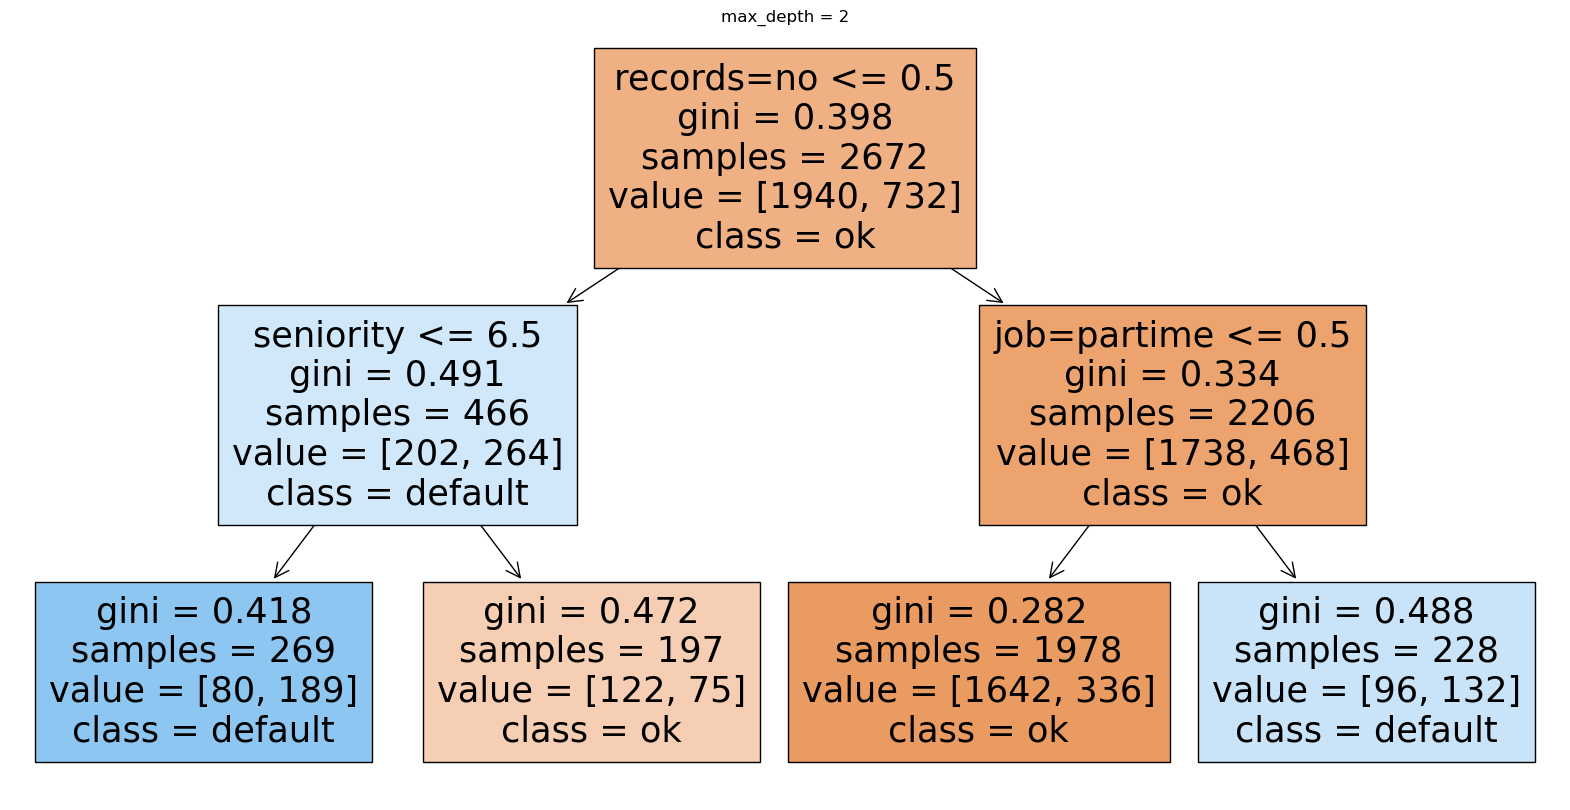

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



In [35]:
feature_names = list(dv.get_feature_names_out())

plt.figure(figsize=(20, 10))
_ = tree.plot_tree(dt, filled=True, feature_names=feature_names, class_names=["ok", "default"]) # 0 -> ok, 1 -> default
plt.title(f"max_depth = {max_depth}")
plt.show()
print(export_text(dt, feature_names=dv.get_feature_names_out()))

The model does not overfit anymore and has drastically imporoved it's AUC-score on the validation-data.

## 6.4 Decision Tree learnign algorithm

- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision Tree learning algorithm

### Finding the best split for one column

Creating an example dataset

In [39]:
data = [
    [8000, "default"],
    [2000, "default"],
    [   0, "default"],
    [5000, "ok"], 
    [5000, "ok"], 
    [4000, "ok"], 
    [9000, "ok"], 
    [3000, "default"]
]

df_example = pd.DataFrame(data, columns=["assets", "status"])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


Finding the best split (threshold) for the feature `assets` 

In [40]:
df_example.sort_values(by="assets")

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
4,5000,ok
3,5000,ok
0,8000,default
6,9000,ok


The thresholds $0$ and $9000$ are not useful. Therefore the set of possible thresholds is $T \in \{2000, 3000, 4000, 5000, 8000\}$. The determined threshold then splits the values of a feature in `LEFT` and `RIGHT`. Lets test out each thresholds mentioned before.

In [43]:
from IPython.display import display

In [47]:
Ts = [2000, 3000, 4000, 5000, 8000]

In [48]:
for T in Ts:
    df_left  = df_example[df_example["assets"] <= T]
    df_right = df_example[df_example["assets"]  > T]

    print(f"T = {T}")
    print("LEFT:")
    display(df_left)
    print("RIGHT:")
    display(df_right)

T = 2000
LEFT:


,assets,status
1,2000,default
2,0,default


RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


T = 3000
LEFT:


,assets,status
1,2000,default
2,0,default
7,3000,default


RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


T = 4000
LEFT:


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


T = 5000
LEFT:


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


RIGHT:


,assets,status
0,8000,default
6,9000,ok


T = 8000
LEFT:


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


RIGHT:


,assets,status
6,9000,ok


But what of those possible splits is the best?

In [53]:
# Lets try out T = 4000
T = 4000

df_left  = df_example[df_example["assets"] <= T]
df_right = df_example[df_example["assets"]  > T]

print(f"T = {T}")
print("LEFT:")
display(df_left)
print(df_left["status"].value_counts(normalize=True))

print("RIGHT:")
display(df_right)
print(df_right["status"].value_counts(normalize=True))

T = 4000
LEFT:


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64
RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64


**Computing the Missclassification Rate**
1. Missclassification Rate in `LEFT` - Should be `default`: $1/4 = 25\\%$
2. Missclassification Rate in `RIGHT` - Should be `ok`: $1/4 = 25\\%$
3. Computing the Average of both values which is 25% here ($\frac{1}{2}(0.25 + 0.25) = 0.25$)

The steps above are done for each possible threshold. This is to find the best (least worse) threshold for splitting a certain feature. In step `3.` a weighted average is used, however because of simplicity a regular average is chosen here!

### Missclassification Rate (Impurity)

The missclassifcation rate (also called impurity) is a metric to assess the "goodness" of a split. The goal is to find the least impure split s.t. the resulting splits `LEFT` and `RIGHT` are as homogenuous as possible.

Finding the best threshold $T$:
1. Iterate through all available $T$'s
2. Perform the `LEFT/RIGHT`-split for each $T$ 
3. Measure the impurity of each $T$
4. Choose the $T$ with the lowest impurity

In [72]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]
for T in Ts:
    print(f"T = {T}")

    df_left  = df_example[df_example["assets"] <= T]
    df_right = df_example[df_example["assets"]  > T]

    print("LEFT:")
    display(df_left)
    print(df_left["status"].value_counts(normalize=True))
    
    print("RIGHT:")
    display(df_right)
    print(df_right["status"].value_counts(normalize=True))

    # `DECISION LEFT` | `IMPURITY LEFT` | `DECISION RIGHT` | `IMPURITY RIGHT` | `AVG`
    decision_left = df_left["status"].value_counts().sort_values(ascending=False).index[0]
    impurity_left = df_left["status"][df_left["status"] != decision_left].count() / len(df_left["status"])

    decision_right = df_right["status"].value_counts().sort_values(ascending=False).index[0]
    impurity_right = df_right["status"][df_right["status"] != decision_right].count() / len(df_right["status"])

    node_avg = (impurity_left + impurity_right) / 2.0
    print(f"T: {T} | LEFT-D: {decision_left} | LEFT-IMP: {impurity_left.round(3)} | " \
          f"RIGHT-D: {decision_right} | RIGHT-IMP: {impurity_right.round(3)} | AVG: {node_avg.round(3)}")



    print("\n\n")



T = 0
LEFT:


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64
RIGHT:


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
T: 0 | LEFT-D: default | LEFT-IMP: 0.0 | RIGHT-D: ok | RIGHT-IMP: 0.429 | AVG: 0.214



T = 2000
LEFT:


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64
RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
T: 2000 | LEFT-D: default | LEFT-IMP: 0.0 | RIGHT-D: ok | RIGHT-IMP: 0.333 | AVG: 0.167



T = 3000
LEFT:


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64
RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
T: 3000 | LEFT-D: default | LEFT-IMP: 0.0 | RIGHT-D: ok | RIGHT-IMP: 0.2 | AVG: 0.1



T = 4000
LEFT:


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64
RIGHT:


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
T: 4000 | LEFT-D: default | LEFT-IMP: 0.25 | RIGHT-D: ok | RIGHT-IMP: 0.25 | AVG: 0.25



T = 5000
LEFT:


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
RIGHT:


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
T: 5000 | LEFT-D: default | LEFT-IMP: 0.5 | RIGHT-D: default | RIGHT-IMP: 0.5 | AVG: 0.5



T = 8000
LEFT:


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64
RIGHT:


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64
T: 8000 | LEFT-D: default | LEFT-IMP: 0.429 | RIGHT-D: ok | RIGHT-IMP: 0.0 | AVG: 0.214





The resulting thresholds and their impurity-score can be seen here:

| $T$    | `DECISION LEFT` | `IMPURITY LEFT` | `DECISION RIGHT` | `IMPURITY RIGHT` | `AVG`   |
| ------ | --------------- | --------------- | ---------------- | ---------------- | ------- |
| $0$    | `DEFAULT`       |   $0\\%$        | `OK`             | $43\\%$          | $21\\%$ |
| $2000$ | `DEFAULT`       |   $0\\%$        | `OK`             | $33\\%$          | $16\\%$ |
| $3000$* | `DEFAULT`       |   $0\\%$        | `OK`             | $20\\%$          | $10\\%$ |
| $4000$ | `DEFAULT`       |   $25\\%$       | `OK`             | $25\\%$          | $25\\%$ |
| $5000$ | `DEFAULT`       |   $50\\%$       | `OK`             | $50\\%$          | $50\\%$ |
| $8000$ | `DEFAULT`       |   $43\\%$       | `OK`             |  $0\\%$          | $21\\%$ |

From the results we can see, that the thresold of $T^* = 3000$ leads to the least impure separation of the assets-features. We therefore choose this as the threshold for the current node of the decision tree. 

### Another try! This time with two features instead of one

In [73]:
data = [
    [8000, 3000, "default"],
    [2000, 1000, "default"],
    [   0, 1000, "default"],
    [5000, 1000, "ok"], 
    [5000, 1000, "ok"], 
    [4000, 1000, "ok"], 
    [9000,  500, "ok"], 
    [3000, 2000, "default"]
]

df_example = pd.DataFrame(data, columns=["assets", "debt", "status"])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [78]:
df_example.sort_values(by="debt")

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


Possible `T`'s can be $T_{debt}\in\{500, 1000, 2000\}$

In [80]:
# using the previously used thresholds for assets and debt
thresholds = { 
    "assets": [0, 2000, 3000, 4000, 5000, 8000],
    "debt": [500, 100, 2000]
}

In [83]:
for feature, Ts in thresholds.items():
    print("\n===========================")
    print("Feature: ", feature)
    for T in Ts:
        print("T = ", T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left["status"].value_counts(normalize=True))
        display(df_right)
        print(df_right["status"].value_counts(normalize=True))



    print("===========================")



Feature:  assets
T =  0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
T =  2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
T =  3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
T =  4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
T =  5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
T =  8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

Feature:  debt
T =  500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64
T =  100


,assets,debt,status


Series([], Name: proportion, dtype: float64)


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
T =  2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64


By extending the table from the single-feature decision tree we get:

| $T$    | `DECISION LEFT` | `IMPURITY LEFT` | `DECISION RIGHT` | `IMPURITY RIGHT` | `AVG`   |
| :----: | :-------------: | :-------------: | :--------------: | :--------------: | :-----: |
| $T_{assets}$ |           |                 |                  |                  |         |
| $0$    | `DEFAULT`       |   $0\\%$        | `OK`             | $43\\%$          | $21\\%$ |
| $2000$ | `DEFAULT`       |   $0\\%$        | `OK`             | $33\\%$          | $16\\%$ |
| $3000$*| `DEFAULT`       |   $0\\%$        | `OK`             | $20\\%$          | $10\\%$ |
| $4000$ | `DEFAULT`       |   $25\\%$       | `OK`             | $25\\%$          | $25\\%$ |
| $5000$ | `DEFAULT`       |   $50\\%$       | `OK`             | $50\\%$          | $50\\%$ |
| $8000$ | `DEFAULT`       |   $43\\%$       | `OK`             |  $0\\%$          | $21\\%$ |
| $T_{debt}$ |             |                 |                  |                  |         |
| $500$  | `OK`            |   $0\\%$        | `DEFAULT`        | $43\\%$          | $21\\%$ |
| $1000$ | `OK`            |   $33\\%$       | `DEFAULT`        | $33\\%$          | $16\\%$ |
| $2000$ | `OK`            |   $43\\%$       | `DEFAULT`        | $20\\%$          | $21\\%$ |

The split along the thresholds of the `debt`-feature did not yield a better result. Therefore the best splitting feature is `assets` with a threshold $T^* = 3000$

**Finding the best split algorithm**:

TODO

## 6.5 Decision Trees parameter tuning

- selecting `max_depth`
- selecting `min_samples_leaf`

## 6.6 Ensembles and random forest

- Board of experts
- Ensemble models
- Random forest - ensembling decision trees
- Tuning random forest

Other usefulv parameters:
- `max_features`
- `bootstrap`

Link: [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

## 6.7 Gradient boosting and XGBoost

- Gradient boosting vs random forest
- Installing `XGBoost`
- Training the first model
- Performance monitoring
- Parsing `XGBoost`'s monitoring output

## 6.8 XGBoost parameter tuning

Tuning the following parameters:
- `eta`
- `max_depth`
- `min_child_weight`

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:
- `subsample` and `colsample_bytree`
- `lambda` and `alpha`

## 6.9 Selecting the final model

- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

## 6.10 Summary

- Decision tree learn if-then-else rule from data
- Finding the best split: select the least impure split. The algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
- Tandom forest is a way of combining multiple decision trees. It should habe a diverse set of models to make good predictions
- Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting